# Basic usage case

This notebook illustrates a simple way to use one of the models trained in this spike finder submission to analyze arbitrary calcium fluorescence data.

Tim Machado <br>
tamachado@stanford.edu <br>
12-2017

In [1]:
import os
import keras
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import scipy.io as sio

import utils

%matplotlib inline

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# Set the figure style
sns.set_style("whitegrid", {'axes.grid' : True})

In [3]:
# A couple of helper functions used below
def normalize(trace):
    return trace/np.nanmax(trace)

def plot_inference(F, s, spikes, neuron_idx):
    plt.figure(figsize=(8, 6))
    plt.plot(normalize(np.array(F)[:, neuron_idx])*3)
    plt.plot(normalize(np.array(s)[:, neuron_idx]) - 2, label='True')
    plt.plot(normalize(np.array(spikes)[:, neuron_idx]) - 4, label='Inference')
    plt.axis('off')
    plt.legend(loc='best', ncol=3)

# Analyze dataset 1 (OGB) using the default spike inference model

Arbitrary calcium data should also work using the approach shown below. For best results, provide raw data at its native resolution (rather than resampled). If you do use upsampled data, you should try different values for the `factor` parameter as shown in this example. This is necessary because we estimate the scale of the noise on the calcium data by making assumptions about the shape of its power spectrum. Resampling the data corrupts the spectrum and thus makes our approach work poorly.

Here we're demonstrating how well a single default model works. But other models were also developed in this spikefinder submission. You can pass them as the `name` argument to utils.infer_spikes (find the paths to the other models in the `Models` subfolder). You should also look at the `Decoder Model Evaluation` notebook to see which model was best for each spikefinder dataset.

Look at the [repository](https://bitbucket.org/tamachado/encoder-decoder/src) for more information.

In [4]:
# Load the first spikefinder dataset
dataset = 1
F, s = utils.load_evaluation_data(dataset)

# Downsample data by this factor before computing parameters/doing spike inference
factor = 3

# Infer spikes on all neurons in the F data frame and compute error rates using ground truth spikes (in s)
spikes, correlation = utils.infer_spikes(F, s, factor=factor)
print('Correlation with ground truth: ', np.median(correlation))

Correlation with ground truth:  0.471824184259


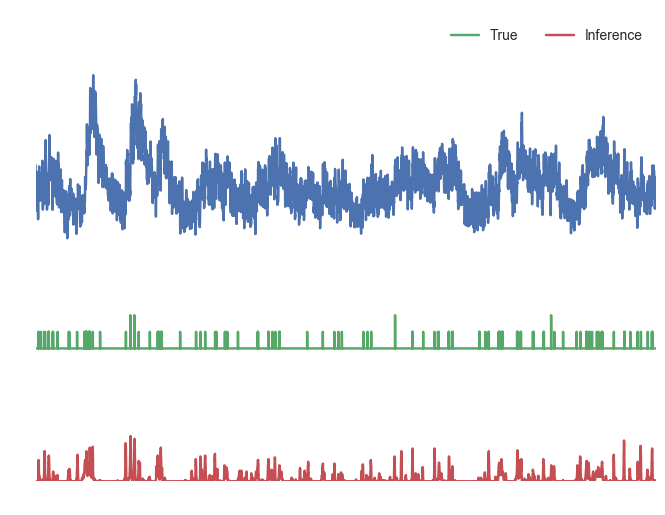

In [5]:
# Plot an example neuron
neuron_index = 3
plot_inference(F, s, spikes, neuron_index)
_ = plt.xlim([15000, 25000])

# Analyze two more datasets: 7 (GCaMP6F) and 8 (GCaMP6S) below.

Because both of these datasets were publically available from Janelia before the challenge, neither one has held out "test" neurons. However, we can use them in such a way because this is spike inference algorithm was not trained on any real data at all. 

These data are not included in the spikefinder repository. Instead, please download the [encoder-decoder](https://bitbucket.org/tamachado/encoder-decoder/src) repository and run this notebook again.

Correlation with ground truth:  0.727272619217


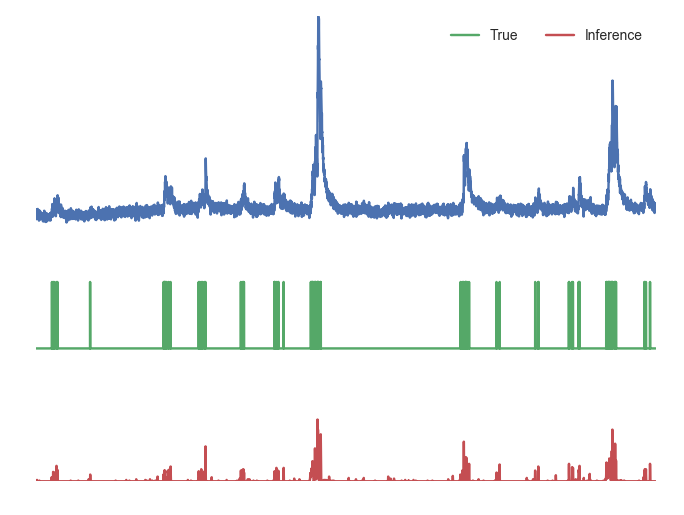

In [6]:
# Load dataset 7 (GCaMP6F)
dataset = 7
F, s = utils.load_evaluation_data(dataset)

# Infer spikes on all neurons in the F data frame and compute error rates using ground truth spikes (in s)
spikes, correlation = utils.infer_spikes(F, s, factor=1)
print('Correlation with ground truth: ', np.median(correlation))

# Plot an example neuron
neuron_index = 3
plot_inference(F, s, spikes, neuron_index)
_ = plt.xlim([0, 10000])

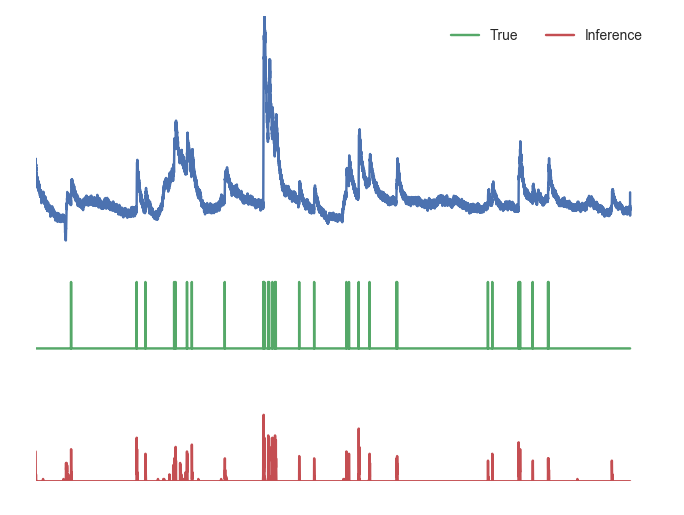

In [7]:
# If spikes are not provided, no ground truth is computed (GCaMP6S)
dataset = 8
F, s = utils.load_evaluation_data(dataset)
spikes = utils.infer_spikes(F)

# Plot an example neuron
neuron_index = 2
plot_inference(F, s, spikes, neuron_index)

# Analyze a few GCaMP3 calcium traces (from Machado et al., Cell, 2015)

These data are very different from the above in terms of indicator (GCaMP3) used and firing rate statistics (1-20 Hz bursts).

They were obtained from spinal motor neurons as opposed to cortical neurons. Nevertheless, the algorithm seems to work well. There is no appreciable fluorescence change below 5 Hz, so spike inference doesn't work well in that regime, but does detect mostly everything else.

In [8]:
def load_antidromic_data(ds):
    """Get GCaMP3 data taken from motor neurons during antidromic stimulation at different frequencies."""
   
    # Load up the mat file containing the raw fluorescence and ground truth spikes
    trial = 0  # Only load the first trial from each dataset
    data = sio.loadmat('Data/antidromic.mat', squeeze_me=True)
    n = data['antidromicData'][ds].item()[3][trial]

    # Indexing weirdness results from importing a mat file
    time = data['antidromicData'][ds].item()[4][0]
    F = data['antidromicData'][ds].item()[5][0]
    if len(np.shape(F)) == 1:
        F = np.expand_dims(F, 0)
    print('dataset date:', data['antidromicData'][ds].item()[0],
          'num cells:', np.shape(F)[0])

    # Vectorize spike times (they are the same for all the cells)
    s = np.zeros(np.shape(F))
    dt = np.median(np.diff(time))
    for t in range(len(n)):
        s[:, int(n[t]/dt)] += 1

    # Return data at native resolution
    return F, s, time

dataset date: 2013-01-10 num cells: 12


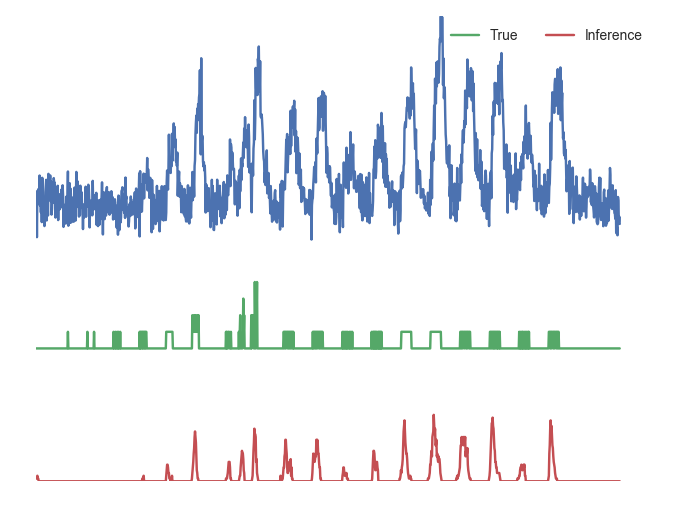

In [9]:
# Plot results
dataset = 1
F, s, time = load_antidromic_data(dataset)
spikes = utils.infer_spikes(F)

neuron_index = 6
plot_inference(F.T, s.T, spikes, neuron_index)